In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from tensorflow import keras
from keras import layers
from keras.regularizers import l2
from keras import callbacks
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("train.csv")
X = data.drop(columns=["Id", "SalePrice"])
y = data["SalePrice"]

In [3]:
for type in ["1Fam", "2fmCon", "Duplex", "TwnhsE", "TwnhsI"]:
  print((X["BldgType"] == type).sum())

1220
31
52
114
0


In [4]:
area_outliers = X[X["LotArea"] > 100000]
area_outliers

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
249,50,RL,NaN,159000,Pave,NaN,IR2,Low,AllPub,CulDSac,...,0,0,NaN,NaN,Shed,500,6,2007,WD,Normal
313,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal
335,190,RL,NaN,164660,Grvl,NaN,IR1,HLS,AllPub,Corner,...,0,0,NaN,NaN,Shed,700,8,2008,WD,Normal
706,20,RL,NaN,115149,Pave,NaN,IR2,Low,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,6,2007,WD,Normal


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

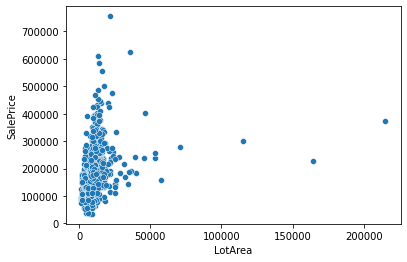

In [6]:
sns.scatterplot(x=X_train["LotArea"], y=y_train)

In [7]:
Xy = X_train.copy()
Xy["SalePrice"] = y_train
outliers = Xy[(Xy["LotArea"] > 50000) | (Xy["SalePrice"] > 500000)]
len(outliers)

13

In [8]:
print(len(Xy))
Xy.drop(index=outliers.index, inplace=True)
print(len(Xy))

1095
1082


In [9]:
y_train = Xy["SalePrice"]
X_train = Xy.drop(columns="SalePrice")

In [10]:
two_family_homes = X_train[X_train["BldgType"] == "2fmCon"]
X_train.drop(index=two_family_homes.index, inplace=True)
y_train.drop(index=two_family_homes.index, inplace=True)

kmeans = KMeans(n_clusters=3)

C = data.loc[:, ["YearBuilt"]]
C["Cluster"] = kmeans.fit_predict(C)

X_train = X_train.join(C, how="left", lsuffix="YearBuilt")
X_train.drop(columns="YearBuilt", inplace=True)
X_val = X_val.join(C, how="left", lsuffix="YearBuilt")
X_val.drop(columns="YearBuilt", inplace=True)

In [11]:
numerical_cols = [col for col in X_train.columns if X_train[col].dtype in ["int64", "float64"]]
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

numerical_transformer = Pipeline(
  steps=[
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler())
  ]
)
categorical_transformer = Pipeline(
  steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
  ]
)

preprocessor = ColumnTransformer(
  transformers=[
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
  ]
)

In [12]:
X_train = pd.DataFrame(preprocessor.fit_transform(X_train).toarray())
X_val = pd.DataFrame(preprocessor.transform(X_val).toarray())

In [13]:
C["Cluster"].value_counts()

1    595
2    591
0    274
Name: Cluster, dtype: int64

In [41]:
n = 1024

model = keras.Sequential([
  #layers.Dense(n, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape=[282]), 
  layers.Dense(n, activation='relu', input_shape=[X_train.shape[1]]),
  layers.Dropout(0.5),
  layers.Dense(n, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(n, activation='relu'),
  layers.Dense(n, activation='relu'),
  layers.Dense(1)
])

early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001,
    patience=20,
    restore_best_weights=True,
)

model.compile(
  optimizer='adam',
  loss='mean_squared_logarithmic_error',
)

history = model.fit(
  #X, y,
  X_train, y_train,
  validation_data=(X_val, y_val),
  batch_size=64,
  epochs=1000,
  callbacks=[early_stopping],
  verbose=1,
)

#history_df = pd.DataFrame(history.history)
#history_df.loc[:, ['loss', 'val_loss']].plot()

Epoch 1/1000
17/17 [==============================] - 1s 30ms/step - loss: 64.4562 - val_loss: 36.9312
Epoch 2/1000
17/17 [==============================] - 0s 23ms/step - loss: 29.2036 - val_loss: 23.1916
Epoch 3/1000
17/17 [==============================] - 0s 22ms/step - loss: 19.8160 - val_loss: 16.8815
Epoch 4/1000
17/17 [==============================] - 0s 21ms/step - loss: 14.9419 - val_loss: 13.1423
Epoch 5/1000
17/17 [==============================] - 0s 21ms/step - loss: 11.8924 - val_loss: 10.6409
Epoch 6/1000
17/17 [==============================] - 0s 25ms/step - loss: 9.7216 - val_loss: 8.8486
Epoch 7/1000
17/17 [==============================] - 0s 21ms/step - loss: 8.1248 - val_loss: 7.5001
Epoch 8/1000
17/17 [==============================] - 0s 24ms/step - loss: 6.9537 - val_loss: 6.4475
Epoch 9/1000
17/17 [==============================] - 0s 23ms/step - loss: 5.9920 - val_loss: 5.6069
Epoch 10/1000
17/17 [==============================] - 0s 23ms/step - loss: 5.253

KeyboardInterrupt: 

In [1]:
def make_submission(model, test_data):
  predictions = model.predict(test_data)
  final_predictions = []
  for i in range(len(predictions)):
    final_predictions.append(predictions[i][0])
  predictions_df = pd.DataFrame(data={"Id": range(1461, 1461 + len(test_data)), "SalePrice": final_predictions})
  predictions_df.to_csv("submission.csv", index=False)

X_test = pd.read_csv("test.csv")
#X_test.drop(columns="YearBuilt", inplace=True)
#X_test = pd.DataFrame(preprocessor.transform(X_test).toarray())
X_test = X_test.join(C, how="left", lsuffix="YearBuilt")
X_test.drop(columns="YearBuilt", inplace=True)
X_test = pd.DataFrame(preprocessor.transform(X_test).toarray())
make_submission(model, X_test)

NameError: name 'pd' is not defined